# InfoGAN

Implementation of InfoGAN on MNIST as proposed by Chen et al., 2016 (https://papers.nips.cc/paper/6399-infogan-interpretable-representation-learning-by-information-maximizing-generative-adversarial-nets.pdf).

## Background

The InfoGAN paper describes an extension of regular GANs that allows to learn salient attributes of the data ("disentangled representation").
To this aim, a subset of the noise variables for the generator input is chosen and the mutual information $I(c; G(z, c))$ between those variables (the code variables $c$) and the generator output $G(z, c)$ is maximized, where $z$ are the remaining noise variables. The mutual information is added as a regularization term to the regular GAN loss function.

Since maximizing the mutual information directly is hard, Chen et al. derive a variational lower bound of the form

\begin{equation}
L_I(G, Q) = \mathbb{E}_{c \sim P(c), x \sim G(z, c)} [\log Q(c|x)] + H(c) \leq I(c; G(z, C)),
\end{equation}

where $Q(c|x)$ is a variational approximation to the posterior $P(c|x)$. In practice, $Q$ is parametrized as a neural network that shares most layers with the discriminiator (just adding an additional hidden layer and the output on top of the last hidden layer of the discriminator).

The additional loss term $L_I$ thus requires the network $Q$ to predict the code $c$ only from the generated images $x = G(z, c)$. Intuitively, this requries the generator to use the code variables in a way that can be deduced from the generated images.

For the MNIST dataset, a natural choise for the code is to use a 10-class categorical distribution that represent the different digits. Additionally, two continuous codes are used that will affect the font (width, rotation).

In [1]:
import tensorflow as tf
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import time
import os

## MNIST

As in Chen et al., 2016, the MNIST dataset is used as a simple test case.

In [2]:
mnist = tf.keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train = np.asarray(x_train / 255.0, dtype=np.float32)
x_test = np.asarray(x_test / 255.0, dtype=np.float32)
train_cat_idx = [np.where(y_train == i)[0] for i in range(0, 10)]
test_cat_idx = [np.where(y_test == i)[0] for i in range(0, 10)]
print('Image shape: {}'.format(x_train[0].shape))

Image shape: (28, 28)


In [3]:
def plot(samples, figsize=(10, 2), gspec=(1, 5)):
    # simple plotting utility for samples
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(*gspec)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample, cmap='Greys_r')

    return fig

In [4]:
buffer_size = 60000
batch_size = 128
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(buffer_size).batch(batch_size).repeat()
test_dataset = tf.data.Dataset.from_tensor_slices(x_test).batch(10000)
iterator = tf.data.Iterator.from_structure(train_dataset.output_types,
                                           train_dataset.output_shapes)
next_element = iterator.get_next()
train_init_op = iterator.make_initializer(train_dataset)
test_init_op = iterator.make_initializer(test_dataset)

## InfoGAN architecture

The same architecture as in Chen et al., 2016 is used.

In [5]:
class InfoGAN:
    
    def __init__(self, x_data, dim_cat=10, dim_unif=2, dim_noise=62, lambda_reg=1):
        
        self.x_data = tf.expand_dims(x_data, 3)
        self.dim_cat = dim_cat
        self.dim_unif = dim_unif
        self.dim_noise = dim_noise
        self.lambda_reg = lambda_reg
        self.model_sig = False # simpler to fit without using std (but should also work if set to True)
        self.TINY = 1e-8
        self.is_training = tf.placeholder_with_default(tf.constant(False), shape=())
        
        # prior samples (categorical, uniform, noise)
        self.prior_cat, self.prior_unif, self.prior_noise = self.prior_sample(self.x_data, self.dim_cat, self.dim_unif,
                                                                              self.dim_noise)

        # generator
        gen_template = tf.make_template('generator', self.build_generator)
        self.x_g = gen_template(self.prior_cat, self.prior_unif, self.prior_noise)
        
        # shared part of discriminator and q network
        shared_template = tf.make_template('shared', self.shared_d_q_net)
        self.shared_out_real = shared_template(self.x_data)
        self.shared_out_fake = shared_template(self.x_g)
        
        # discriminator
        d_template = tf.make_template('discriminator', self.discriminator_output)
        self.d_logits_real, self.d_real = d_template(self.shared_out_real)
        self.d_logits_fake, self.d_fake = d_template(self.shared_out_fake)
        
        # q network
        q_template = tf.make_template('qnetwork', self.q_output)
        self.q_logits_cat, self.q_mean_unif, self.q_log_std_unif, self.q_probs_cat = \
            q_template(self.shared_out_fake, self.dim_cat, self.dim_unif)
        
        # var lists for optimizer
        self.g_vars = tf.trainable_variables(scope='generator')
        self.d_vars = tf.trainable_variables(scope='[shared|discriminator].*')
        self.q_vars = [var for var in tf.trainable_variables(scope='[shared|qnetwork].*') if 'discriminator' not in var.name]
        
        # gan loss
        self.loss_g, self.loss_d = self.gan_loss()
        
        # MI loss
        self.loss_q = self.mi_loss()
        
        # solver
        self.build_solver()
        
        # for evaluation create run networks from placeholder (do this here, otherwise batch_norm complains)
        self.z_pl = tf.placeholder(tf.float32, shape=(None, dim_cat + dim_unif + dim_noise), name='z_manual')
        self.x_g_from_z_pl = gen_template(full_latent=self.z_pl)
        self.x_pl = tf.placeholder(tf.float32, shape=(None, 28, 28, 1))
        self.q_from_x_pl = q_template(shared_template(self.x_pl), self.dim_cat, self.dim_unif)
        
    def prior_sample(self, x, dim_cat, dim_unif, dim_noise):
        cat = tf.distributions.Categorical(probs=[1. / dim_cat] * 10).sample(sample_shape=(tf.shape(x)[0],))
        cat = tf.one_hot(cat, dim_cat)
        unif = tf.random_uniform((tf.shape(x)[0], dim_unif), minval=-1., maxval=1.)
        noise = tf.random_normal((tf.shape(x)[0], dim_noise))
        return cat, unif, noise
    
    def concat_prior_sample(self):
        # for debugging
        return tf.concat((self.prior_cat, self.prior_unif, self.prior_noise), axis=1)
    
    def build_generator(self, cat=None, unif=None, noise=None, full_latent=None):
        if full_latent is not None:
            h = full_latent
        else:
            h = tf.concat((cat, unif, noise), axis=1)
        act = tf.nn.relu
        h = tf.layers.dense(h, 1024)
        h = tf.layers.batch_normalization(h, training=self.is_training)
        h = act(h)
        h = tf.layers.dense(h, 7*7*128)
        h = tf.layers.batch_normalization(h, training=self.is_training)
        h = act(h)
        h = tf.reshape(h, [-1, 7, 7, 128])
        h = tf.layers.conv2d_transpose(h, 64, [4, 4], strides=2, padding="same")
        h = tf.layers.batch_normalization(h, training=self.is_training)
        h = act(h)
        h = tf.layers.conv2d_transpose(h, 1, [4, 4], strides=2, activation=tf.nn.sigmoid, padding="same")
        return h
    
    def shared_d_q_net(self, x):
        h = x
        act = tf.nn.leaky_relu
        h = tf.layers.conv2d(h, 64, 4, strides=2, activation=act)
        h = tf.layers.conv2d(h, 128, 4, strides=2)
        h = tf.layers.batch_normalization(h, training=self.is_training)
        h = act(h)
        h = tf.layers.flatten(h)
        h = tf.layers.dense(h, 1024)
        h = tf.layers.batch_normalization(h, training=self.is_training)
        h = act(h)
        return h
    
    def discriminator_output(self, shared_output):
        h = shared_output
        d_logits = tf.layers.dense(h, 1)
        d_probs = tf.nn.sigmoid(d_logits)
        return d_logits, d_probs
    
    def q_output(self, shared_output, dim_cat, dim_unif):
        act = tf.nn.leaky_relu
        h = shared_output
        h = tf.layers.dense(h, 128)
        h = tf.layers.batch_normalization(h, training=self.is_training)
        h = act(h)
        logits_cat = tf.layers.dense(h, dim_cat)
        probs_cat = tf.nn.softmax(logits_cat)
        mean_unif = tf.layers.dense(h, dim_unif)
        if self.model_sig:
            log_std_unif = tf.layers.dense(h, dim_unif)
        else:
            log_std_unif = tf.zeros_like(mean_unif, dtype=tf.float32)
        return logits_cat, mean_unif, log_std_unif, probs_cat
    
    def gan_loss(self):
        # using tf losses
        loss_d_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.d_logits_real,
                                                                             labels=tf.ones_like(self.d_logits_real)))
        loss_d_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.d_logits_fake,
                                                                             labels=tf.zeros_like(self.d_logits_fake)))
        loss_d = loss_d_real + loss_d_fake
        loss_g = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.d_logits_fake,
                                                                        labels=tf.ones_like(self.d_logits_fake)))
        return loss_g, loss_d
    
    def mi_loss_cont(self, prior, q_mean, q_log_std=None, q_std=None):
        # though the continous variables are sampled from unif([-1, 1]), they are modelled as gaussian by q
        # if not self.model_sig:
        #     return tf.losses.mean_squared_error(labels=prior, predictions=q_mean)
        if q_log_std is not None:
            eps = tf.square((prior - q_mean) / tf.exp(q_log_std))
            return tf.reduce_mean(tf.reduce_sum(0.5 * tf.log(2 * np.pi) + q_log_std + 0.5 * eps, axis=1))
        elif q_std is not None:
            eps = tf.square((prior - q_mean) / (q_std + self.TINY))
            return tf.reduce_mean(tf.reduce_sum(0.5 * tf.log(2 * np.pi) + tf.log(q_std + self.TINY) + 0.5 * eps, axis=1))
        else:
            raise RuntimeError('Specify q_log_std or q_std.')
    
    def mi_loss_cat(self, prior, q_cat_logits):
        prior = tf.stop_gradient(prior)
        return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=prior, logits=q_cat_logits))
    
    def mi_loss(self):
        loss = self.mi_loss_cont(self.prior_unif, self.q_mean_unif, self.q_log_std_unif)
        loss += self.mi_loss_cat(self.prior_cat, self.q_logits_cat)
        return loss
    
    def build_solver(self, lr_g=5e-4, lr_d=5e-4):
        
        # generator & regularizer
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
            solver_g = tf.train.AdamOptimizer(lr_g).minimize(self.loss_g, var_list=self.g_vars)
            solver_d = tf.train.AdamOptimizer(lr_d).minimize(self.loss_d, var_list=self.d_vars)
            solver_q = tf.train.AdamOptimizer(lr_g).minimize(self.lambda_reg * self.loss_q, var_list=self.g_vars + self.q_vars)
        
        self.solver_g = solver_g
        self.solver_d = solver_d
        self.solver_q = solver_q

In [6]:
igan = InfoGAN(next_element, lambda_reg=1)

In [7]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [8]:
def sample_categories(igan, sess):
    N = 100

    cat = np.zeros((N, 10))

    n_per_cat = 10
    for i in np.arange(0, 10):
        cat[(i*n_per_cat):(i*n_per_cat)+n_per_cat, i] = 1

    unif = (np.random.rand(N, 2) * 2 - 1)
    # unif = np.zeros((N, 2))
    noise = np.random.randn(N, 62)

    z = np.concatenate((cat, unif, noise), axis=1)
    s = sess.run(igan.x_g_from_z_pl, feed_dict={igan.z_pl: z})
    s = np.squeeze(s)

    plot(s[:,:,:], figsize=(15, 15), gspec=(10, 10));
    plt.clim(0, 1)
    plt.show()

# Training

Iter: 1
G_loss: 0.5945
D loss: 1.65
Q loss: 5.869
Total runtime 3.52s



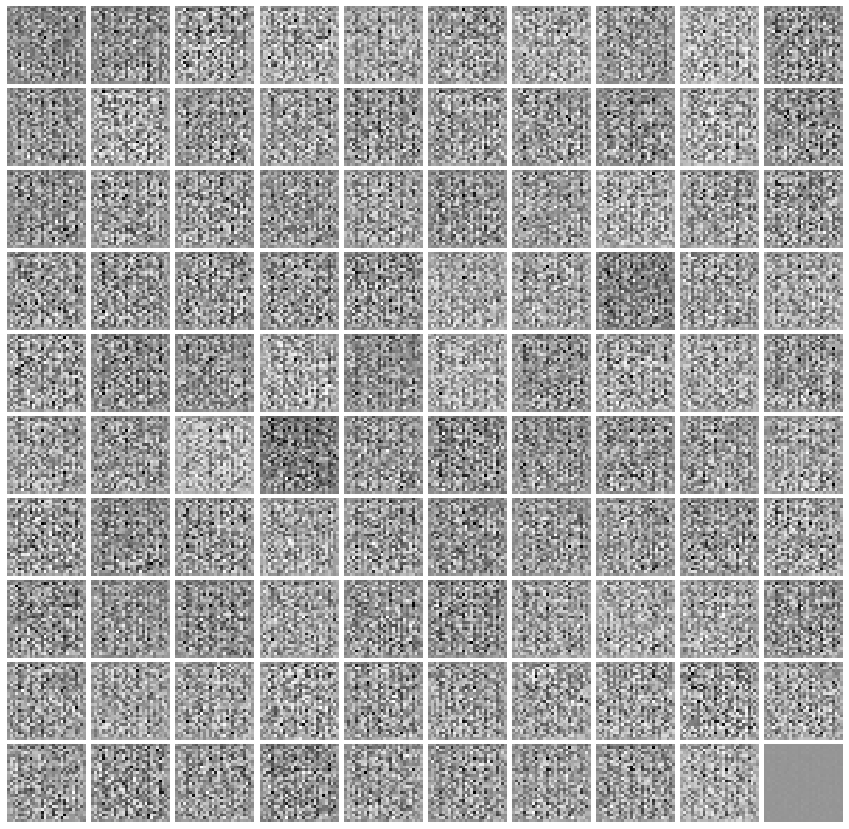

Iter: 10000
G_loss: 2.107
D loss: 0.9176
Q loss: 1.857
Total runtime 383.52s



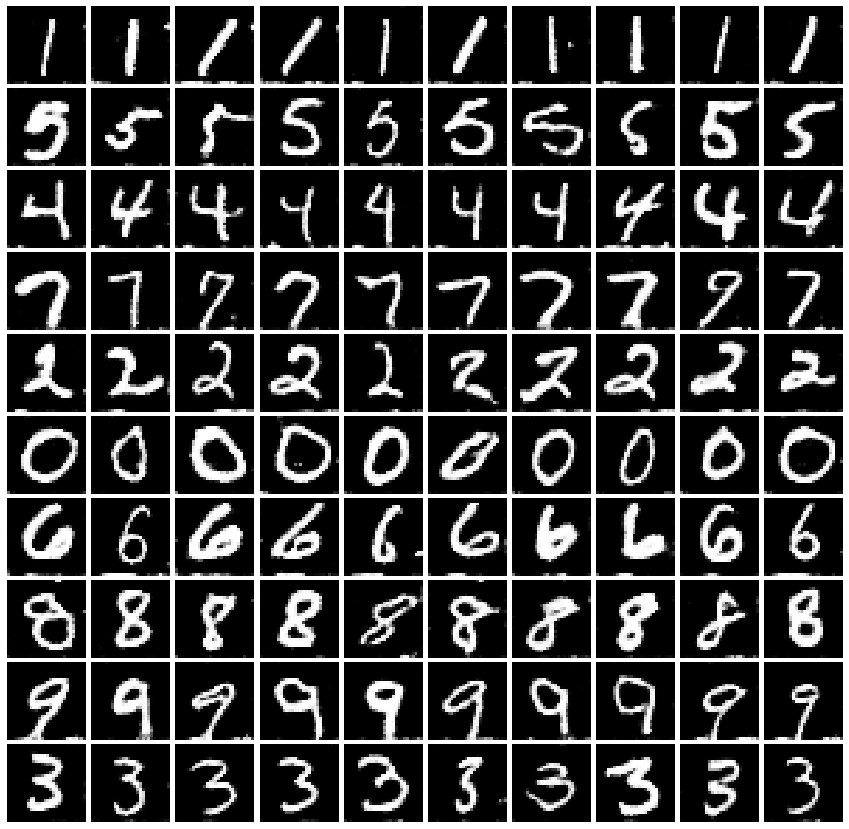

Iter: 20000
G_loss: 2.044
D loss: 0.7821
Q loss: 1.868
Total runtime 770.76s



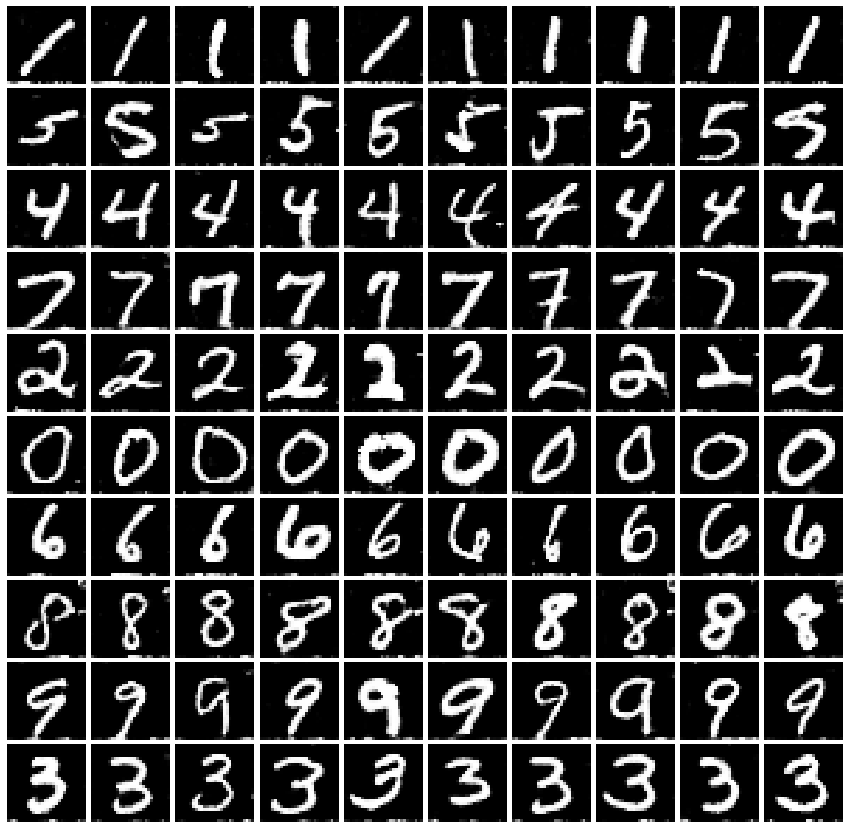

Iter: 30000
G_loss: 1.577
D loss: 0.764
Q loss: 1.848
Total runtime 1163.93s



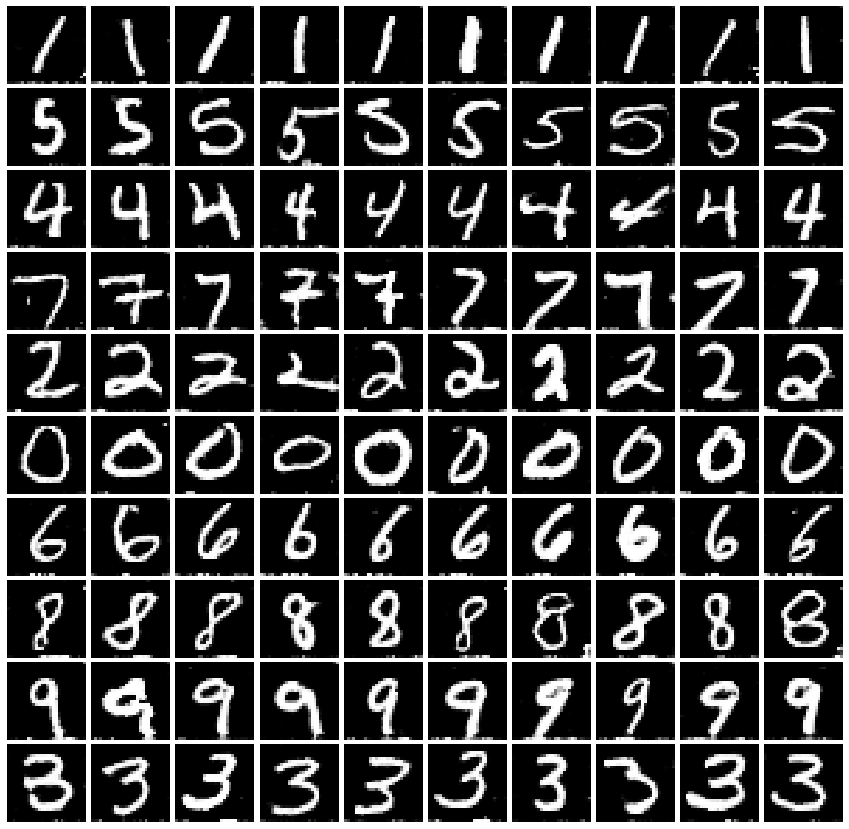

'./InfoGAN_ckpts/model.ckpt-Final'

In [9]:
sess.run(train_init_op)
num_it = 30000
log_steps = 10000 #  step size for logging and checkpoint saving during training
loss_step = 500 # step size to record loss

save_path = './InfoGAN_ckpts/'
if not os.path.exists(save_path):
    os.makedirs(save_path)
saver = tf.train.Saver()

log_step = 0
t_0 = time.time()
loss_g = []
loss_d = []
loss_q = []
for it in range(num_it):
    
    # train discriminator
    _, loss_d_cur = sess.run([igan.solver_d, igan.loss_d], feed_dict={igan.is_training: True})

    # train generator
    _, loss_g_cur = sess.run([igan.solver_g, igan.loss_g], feed_dict={igan.is_training: True})
    
    # train encoder
    _, loss_q_cur = sess.run([igan.solver_q, igan.loss_q], feed_dict={igan.is_training: True})

    if (it + 1) % loss_step == 0 or it == 0:
        loss_d.append(loss_d_cur)
        loss_g.append(loss_g_cur)
        loss_q.append(loss_q_cur)

    if (it + 1) % log_steps == 0 or it == 0:
        t = time.time()
        print('Iter: {}'.format(it+1))
        print('G_loss: {:.4}'.format(loss_g_cur))
        print('D loss: {:.4}'.format(loss_d_cur))
        print('Q loss: {:.4}'.format(loss_q_cur))
        print('Total runtime {:.2f}s'.format(t - t_0))
        print()
        sample_categories(igan, sess)
        saver.save(sess, os.path.join(save_path, "model.ckpt-{}".format(it+1)))

saver.save(sess, os.path.join(save_path, "model.ckpt-Final"))

# Training loss

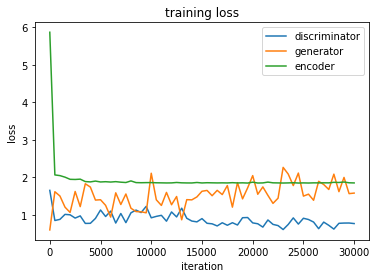

In [10]:
x = np.arange(0, num_it + 1, loss_step)
plt.plot(x, loss_d, label='discriminator')
plt.plot(x, loss_g, label='generator')
plt.plot(x, loss_q, label='encoder')
plt.title('training loss')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.legend();

# Samples with different discrete code (rows)

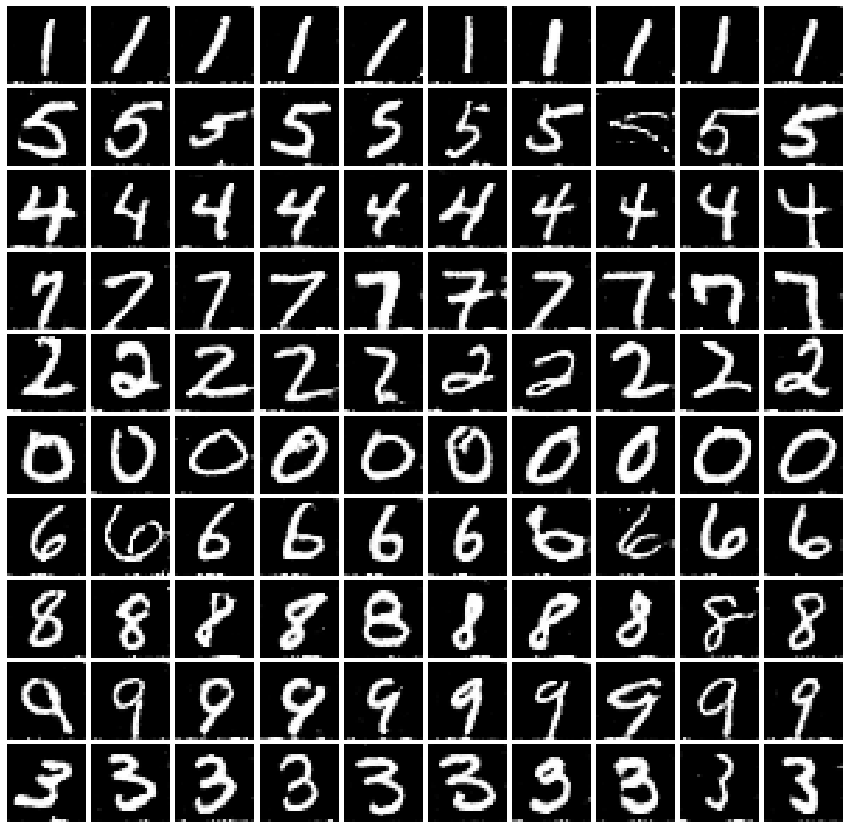

In [11]:
sample_categories(igan, sess)

# Infer categories from test set

In [12]:
q_cat = sess.run(igan.q_from_x_pl, feed_dict={igan.x_pl: x_test[:, :, :, np.newaxis]})[3]
q_cat = np.argmax(q_cat, axis=1)
q_cat_idx = [np.where(q_cat == i)[0] for i in range(0, 10)]
q_cat_label = np.asarray([np.median(y_test[x]) for x in q_cat_idx], dtype=np.uint8)
q_cat_label

array([1, 5, 4, 7, 2, 0, 6, 8, 9, 3], dtype=uint8)

# Samples with varying continous code

Samples from category 1, both continous codes varied.

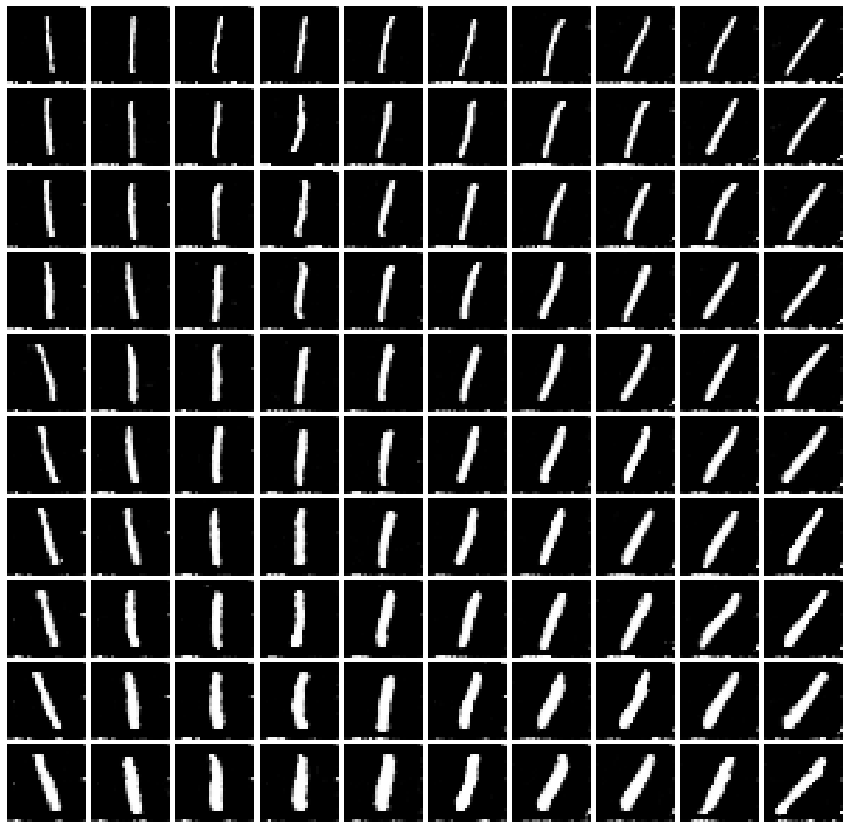

In [13]:
N = 100

cat = np.zeros((N, 10))
this_cat = np.argmax(q_cat_label == 1)
cat[:, this_cat] = 1

xx, yy = np.meshgrid(np.linspace(-1., 1., 10), np.linspace(-1., 1., 10))
unif = np.concatenate((xx.reshape([-1, 1]), yy.reshape([-1, 1])), axis=1)
noise = np.random.randn(N, 62)

z = np.concatenate((cat, unif, noise), axis=1)
s = sess.run(igan.x_g_from_z_pl, feed_dict={igan.z_pl: z})
s = np.squeeze(s)

plot(s[:,:,:], figsize=(15, 15), gspec=(10, 10));
plt.clim(0, 1)

Samples from category 6, both continous codes varied.

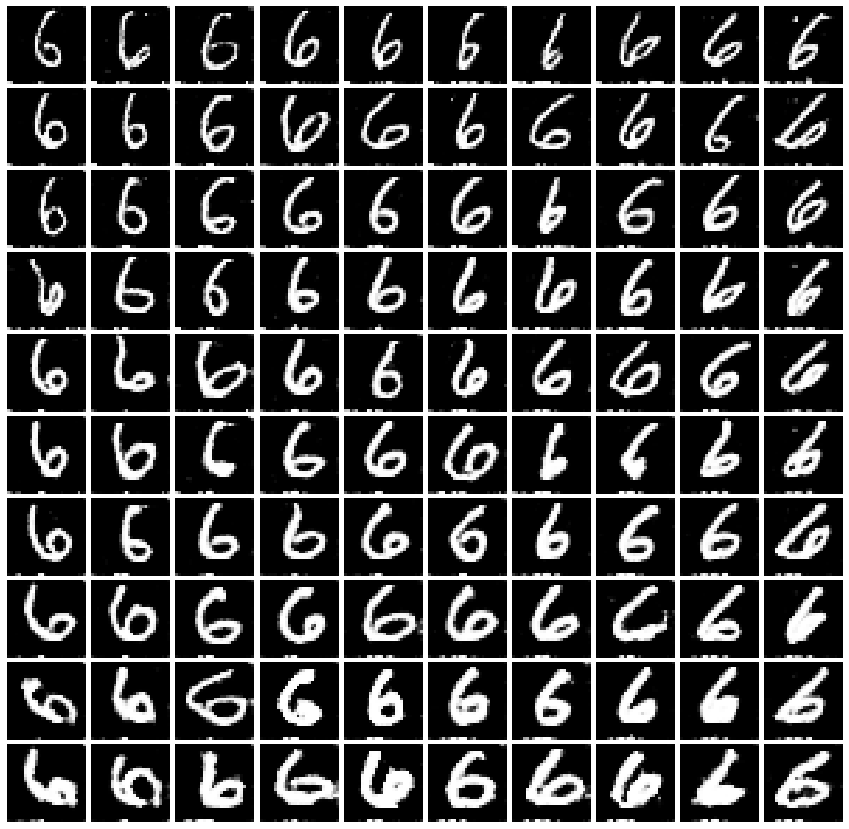

In [14]:
N = 100

cat = np.zeros((N, 10))
this_cat = np.argmax(q_cat_label == 6)
cat[:, this_cat] = 1

xx, yy = np.meshgrid(np.linspace(-1., 1., 10), np.linspace(-1., 1., 10))
unif = np.concatenate((xx.reshape([-1, 1]), yy.reshape([-1, 1])), axis=1)
noise = np.random.randn(N, 62)

z = np.concatenate((cat, unif, noise), axis=1)
s = sess.run(igan.x_g_from_z_pl, feed_dict={igan.z_pl: z})
s = np.squeeze(s)

plot(s[:,:,:], figsize=(15, 15), gspec=(10, 10));
plt.clim(0, 1)

First continuous code variable fixed.

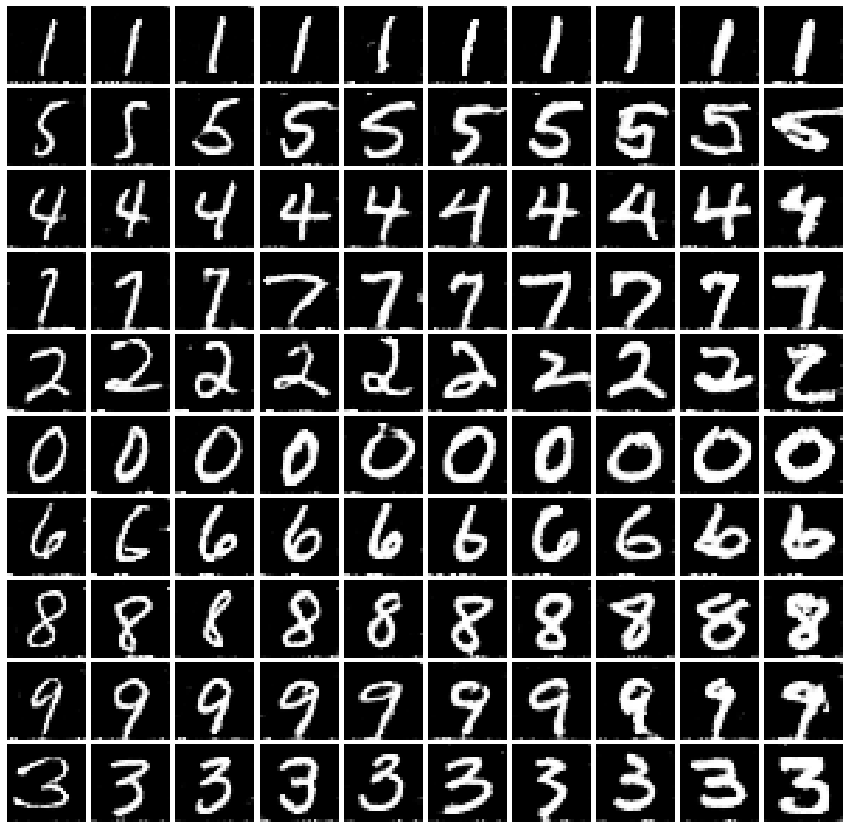

In [15]:
N = 100

cat = np.zeros((N, 10))

n_per_cat = 10
for i in np.arange(0, 10):
    cat[(i*n_per_cat):(i*n_per_cat)+n_per_cat, i] = 1

xx, yy = np.meshgrid(np.linspace(-1., 1., 10), np.zeros(10))
unif = np.concatenate((yy.reshape([-1, 1]), xx.reshape([-1, 1])), axis = 1)
noise = np.random.randn(N, 62)

z = np.concatenate((cat, unif, noise), axis=1)
s = sess.run(igan.x_g_from_z_pl, feed_dict={igan.z_pl: z})
s = np.squeeze(s)

plot(s[:,:,:], figsize=(15, 15), gspec=(10, 10));
plt.clim(0, 1)

Second continuous code variable fixed.

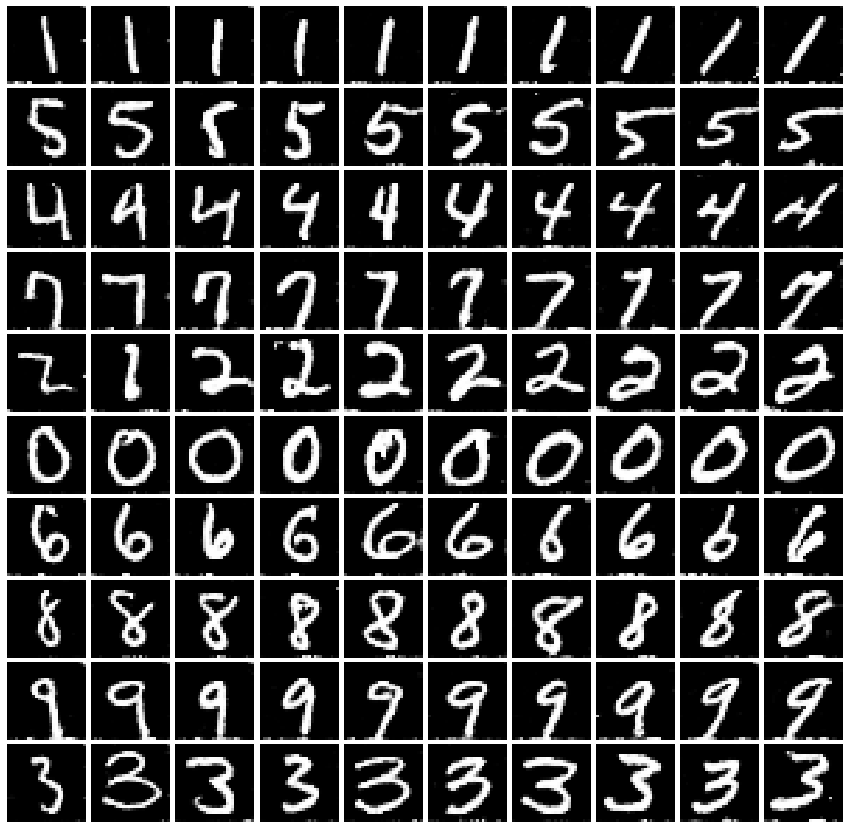

In [16]:
N = 100

cat = np.zeros((N, 10))

n_per_cat = 10
for i in np.arange(0, 10):
    cat[(i*n_per_cat):(i*n_per_cat)+n_per_cat, i] = 1

xx, yy = np.meshgrid(np.linspace(-1., 1., 10), np.zeros(10))
unif = np.concatenate((xx.reshape([-1, 1]), yy.reshape([-1, 1])), axis = 1)
noise = np.random.randn(N, 62)

z = np.concatenate((cat, unif, noise), axis=1)
s = sess.run(igan.x_g_from_z_pl, feed_dict={igan.z_pl: z})
s = np.squeeze(s)

plot(s[:,:,:], figsize=(15, 15), gspec=(10, 10));
plt.clim(0, 1)

# Discriminator output distribution (test set)

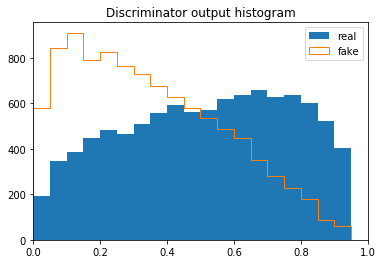

In [17]:
sess.run(test_init_op)
d_true, d_fake = sess.run([igan.d_real, igan.d_fake])
plt.hist(d_true, label='real', bins=np.arange(0, 1, 0.05))
plt.hist(d_fake, label='fake', bins=np.arange(0, 1, 0.05), histtype='step')
plt.xlim(0, 1);
plt.legend();
plt.title('Discriminator output histogram');